# **Determining a Driver's Inebriation Status using Regression Analysis**
Joseph Penovich - UID: 117210156<br>
CMSC320: Introduction to Data Science - Summer 2023<br>
Due August 20th, 2023

## Table of Contents
insert table of contents
## Introduction
### Background
The United States has one of the highest rates of deaths caused by vehicles accidents involving alcohol, which is difficult to attribute to any one factor. Arguments can be made about factors including the US's car dependent infrastructure, it's culture and stigma surrounding drinking alcohol, local state and county traffic legislation, and more. One thing that can be agreed upon is that there is absolutely no reason or justification for driving while under the influence. It can be difficult for police to determine whether a traffic incident involves alcohol without conducting sobriety tests on those involved. 

This project seeks to identify factors that may indicate whether or not an accident involves an inebriated driver(s) using exploratory data analysis, and make predictions on a drivers inebriation tests using machine learning techniques such as logistic regression before police have the chance to conduct sobriety tests on involved individuals. 
### Data 
Montgomery County is Maryland's most populated county, and its residents come from a wide range of socioeconomic backgrounds. The data used in this project is a compiled list of traffic incidents involving collisions in Montgomery County from (date) to (date). This data was retrieved from the **U.S. Governments Public Open Data** site (`https://data.gov`) in addition to Montgomery County's Public Database, **Data Montgomery** (`https://data.montgomerycountymd.gov/`). The data includes factors such as Crash Date & Time, Injury Severity, Vehicle Damage Extent, Driver Substance Abuse, and more. 
***
## **Part 1: Data Collection, Parsing, and Management**
Let's get all the imports that we're going to use for this project, as well as our datasets.<br>
We'll be using two datasets provided by Data Montgomery, which are the datasets **"Crash Reporting - Drivers Data"**, which includes information of the driver(s) in an incident, and **"Crash Reporting - Incidents Data**, which includes general information about the incident itself. The dataset files for this project were downloaded into the directory rather than retrieved using queries. 

**Crash Reporting - Drivers Data:** `https://data.montgomerycountymd.gov/Public-Safety/Crash-Reporting-Drivers-Data/mmzv-x632`
**Crash Reporting - Incidents Data:** `https://data.montgomerycountymd.gov/Public-Safety/Crash-Reporting-Incidents-Data/bhju-22kf`

In [54]:
# Necessary imports for data management, exploration, and machine learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Format dataset into Pandas Dataframe
driverData = pd.read_csv('moco_crash_data_drivers.csv', dtype={'Local Case Number':'str'})
incidentData = pd.read_csv('moco_crash_data_incidents.csv')
print(f"Driver shape: {driverData.shape}, Incident shape: {incidentData.shape}")

In [ ]:
print(driverData.head(1000).to_string())

In [ ]:
print(incidentData.head(1000).to_string())

What we're curious about is what actually is the difference between the two datasets? We know that the drivers data includes more information about the driver, while the incidents data includes more general information, but what specifically so we know what to merge and what to drop?

In [25]:
# Get the variables for each data set
driversVars = np.array(driverData.columns)
incidentVars = np.array(incidentData.columns)
# Find the unique variable names in each
sharedVars = np.intersect1d(driversVars, incidentVars)
driversUniqueVars = np.setdiff1d(driversVars, sharedVars)
incidentUniqueVars = np.setdiff1d(incidentVars, sharedVars)
print(f"Shared Variables: {str(sharedVars)}")
print(f"Driver Data: {str(driversUniqueVars)}")
print(f"Incident Data: {str(incidentUniqueVars)}")

Shared Variables: ['ACRS Report Type' 'Agency Name' 'Collision Type' 'Crash Date/Time'
 'Cross-Street Name' 'Cross-Street Type' 'Driver Substance Abuse'
 'Latitude' 'Light' 'Local Case Number' 'Location' 'Longitude'
 'Municipality' 'Non-Motorist Substance Abuse' 'Off-Road Description'
 'Related Non-Motorist' 'Report Number' 'Road Name' 'Route Type'
 'Surface Condition' 'Traffic Control' 'Weather']
['Circumstance' 'Driver At Fault' 'Driver Distracted By'
 'Driverless Vehicle' 'Drivers License State' 'Equipment Problems'
 'Injury Severity' 'Parked Vehicle' 'Person ID' 'Speed Limit'
 'Vehicle Body Type' 'Vehicle Continuing Dir' 'Vehicle Damage Extent'
 'Vehicle First Impact Location' 'Vehicle Going Dir' 'Vehicle ID'
 'Vehicle Make' 'Vehicle Model' 'Vehicle Movement'
 'Vehicle Second Impact Location' 'Vehicle Year']
['At Fault' 'Direction' 'Distance' 'Distance Unit' 'First Harmful Event'
 'Fixed Oject Struck' 'Hit/Run' 'Intersection Area' 'Intersection Type'
 'Junction' 'Lane Direction' 'L

Looking at the shared variables, there's important information that will help with the merge between the sets, like `Report Number` and `Driver Substance Abuse`. Each dataset has their own unique set of variables that's important to consider when performing our data analysis and regression. For example, the drivers data has information like `Injury Severity`, `Vehicle Damage Extent`, `Speed Limit`, `Vehicle Body Type`, and more. The incident data has information on `Hit/Run`, `First Harmful Event`, `Junctions`, and more which we will include. Some of the information between the two data sets have different column names, but the values are the same or similar like `Driver At Fault` in drivers data and `At Fault` in incidents data, 

So, what kind of information is important for regression analysis? Or more importantly, what information is not important and won't/can't be used, and that can be dropped from the datasets.<br>
**Unimportant Information:**
- `Local Case Number` ; There is already Report Number, which is more specific and suited to this projects purposes
- `Offroad Description`, Circumstance ; Descriptions are too specific to connect with other information
- `Vehicle Continuing Dir`, `Vehicle Going Dir` ; Direction of travel, but what angle the other vehicle was hit may be important
- `Location`, `Longitude`, and `Latitude` ; This project is not concerned with geographical data, since there is Municipality
- `Person ID` ; Not concerned with specific identities
- `Driverless Vehicle` ; Non applicable, driverless vehicles cannot drink and drive (that is known of)
- `Cross-Street Type`, `Cross-Street Name` ; Only concerned with single road name 
- `At Fault` ; There is already `Driver At Fault` in driver data
- `Mile Point`, `Mile Point Direction`, `Lane Direction`, `Lane Number`, `Distance Unit`<br>

Now let's get our merged data minus all unimportant information

In [45]:
# Make a list of all the vars to drop
unnecessary_vars = ['Local Case Number', 'Off-Road Description', 'Vehicle Continuing Dir', 
'Vehicle Going Dir', 'Location', 'Longitude', 'Latitude', 'Person ID',
'Driverless Vehicle', 'Cross-Street Type', 'Cross-Street Name', 'At Fault', 'Mile Point',
'Mile Point', 'Mile Point Direction', 'Lane Direction', 'Lane Number', 'Distance Unit']
# Merge using shared Variables to ensure no incidents with same report number but different attributes
data = pd.merge(driverData, incidentData, how='inner', on=list(sharedVars))
data.drop(columns=unnecessary_vars, inplace=True)
print(data.head(10).to_string())

  Report Number                Agency Name       ACRS Report Type         Crash Date/Time        Route Type       Road Name Municipality Related Non-Motorist           Collision Type  Weather Surface Condition           Light Traffic Control Driver Substance Abuse Non-Motorist Substance Abuse Driver At Fault     Injury Severity Circumstance            Driver Distracted By Drivers License State                            Vehicle ID Vehicle Damage Extent Vehicle First Impact Location Vehicle Second Impact Location                                       Vehicle Body Type         Vehicle Movement  Speed Limit Parked Vehicle  Vehicle Year Vehicle Make Vehicle Model Equipment Problems Hit/Run Lane Type  Number of Lanes Direction  Distance Road Grade NonTraffic First Harmful Event Second Harmful Event Fixed Oject Struck              Junction      Intersection Type Intersection Area Road Alignment Road Condition                              Road Division
0   MCP3040003N   Montgomery County Poli

Now the data is more clean, only including the variables that we consider important. We can do some more cleaning of the data and aggregate some values. 

## **Part 2: Data Exploration and Analysis**
First let's find the roads with the most incidents 

35


Text(0.5, 1.0, 'Number of Vehicle Collisions > 750 on Montgomery County Roads')

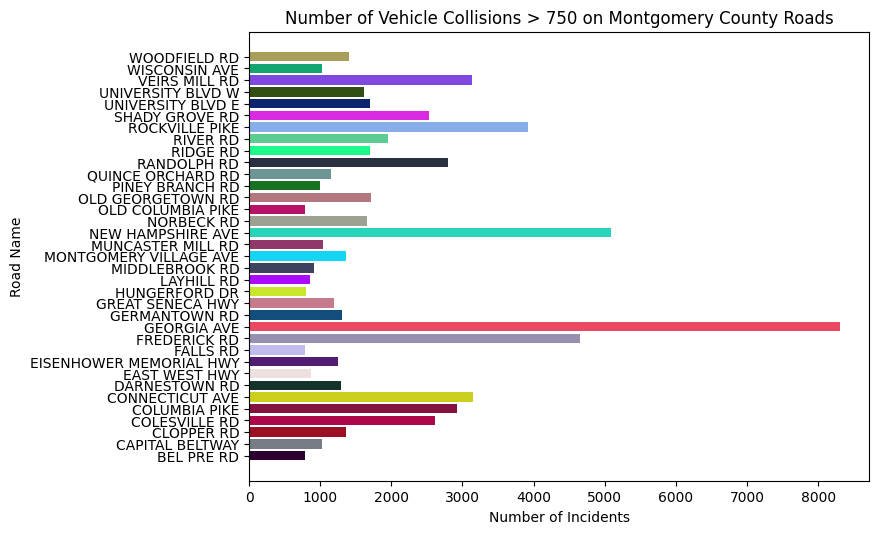

In [72]:
# Find roads with at least inc_num incidents
# Minimum number of incidents
inc_num = 750
mostInc = data.value_counts(subset='Road Name', sort=False)
mostInc = mostInc[mostInc > inc_num]
# Plot data and format graph
plt.figure(figsize=(8, len(mostInc)/6))
colors = list(tuple(np.random.random() for i in np.arange(3)) for j in np.arange(len(mostInc)))
plt.barh(y=mostInc.index, width=mostInc, color=colors)
plt.xlabel("Number of Incidents")
plt.ylabel("Road Name")
plt.title(f"Number of Vehicle Collisions > {inc_num} on Montgomery County Roads")


In [83]:
print(data['Driver Substance Abuse'].unique())
data['drivingDrunk'] = 'ALCOHOL' in data['Driver Substance Abuse']
print(data[['Driver Substance Abuse', 'drivingDrunk']].head(30).to_string())

['UNKNOWN' nan 'NONE DETECTED' 'ALCOHOL PRESENT'
 'COMBINED SUBSTANCE PRESENT' 'ILLEGAL DRUG PRESENT'
 'ILLEGAL DRUG CONTRIBUTED' 'ALCOHOL CONTRIBUTED' 'MEDICATION PRESENT'
 'MEDICATION CONTRIBUTED' 'COMBINATION CONTRIBUTED' 'OTHER']
   Driver Substance Abuse  drivingDrunk
0                 UNKNOWN         False
1                     NaN         False
2                 UNKNOWN         False
3                 UNKNOWN         False
4                     NaN         False
5                     NaN         False
6                     NaN         False
7                     NaN         False
8                     NaN         False
9           NONE DETECTED         False
10          NONE DETECTED         False
11          NONE DETECTED         False
12          NONE DETECTED         False
13          NONE DETECTED         False
14          NONE DETECTED         False
15          NONE DETECTED         False
16          NONE DETECTED         False
17          NONE DETECTED         False
18    